# GEV Classifier 

The algorithm is described in a [paper](https://arxiv.org/pdf/1808.09902.pdf) by Edoardo Vignotto and Sebastian Engelke titled **"Extreme Value Theory for Open Set Classification – GPD and GEV Classifiers"**

The goal is to develop algorithms able to distinguish between known and unknown new data.

**Import libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import scipy.stats as stats

**Simulated Data**

Simulate the known and unknown data sets from a bivariate normal distribution with different parameters.

In [154]:
n = 1000
original=np.random.multivariate_normal([-5, -5], [[1, 0], [0, 1]], n)
new=np.random.multivariate_normal([-8, -8], [[1, 0], [0, 1]], 5)

View the two data sets.

<Figure size 720x504 with 0 Axes>

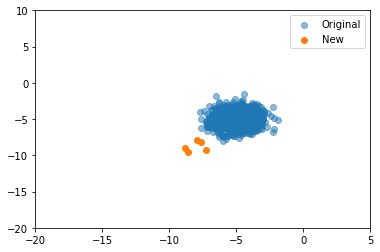

In [155]:
plt.figure(figsize=(10, 7))
fig, ax = plt.subplots()

plt.xlim([-20, 5])
plt.ylim([-20, 10])

#circle = plt.Circle((new[:, 0],new[:, 1] ), radius = 7, color='r', fill=False)

plt.scatter(original[:, 0], original[:, 1], alpha=0.5, label='Original')
plt.scatter(new[:, 0], new[:, 1], alpha=1, label='New')

#ax.set_aspect('equal', adjustable='datalim')
#ax.add_patch(circle)

plt.legend()
plt.show()

## Algorithm

It was [shown](https://arxiv.org/pdf/1506.06112.pdf) (Thm 2.) that -D = max(-|x-y|) can be fit with the Reversed Weibull distribution. The reversed Weibull is a distribution family that is a part of the extreme value distributions and has an upper bound (supported from negative infinity to zero).


This implies that we can fit D = min(|x-y|) (changing variables back to D from -D) to the Weibull distribution.

**1)** For all i in n, we compute the distance between the training point and the nearest training point to it. This is denoted by D = min|x_i - x_j|. Remember that the distance between a point and itself is zero, and these distances need to be disregarded. We are using a fast neighbour search, which requires to compute only O(n log n) distances.

**2)** The distances -D = max(-|x_i-x_j|) are bounded above by zero,  and we can fit a reversed Weibull dist to these maximum negated distances. Alternatively, we can also fit a "Normal" Weibull to the distances D. 

**3)** When a new point arises (x_0), we want to mark the point as either known or unknown. We consider the statistic -d = max(-|x_i-x_0|)  (or d = min|x_i - x_j| in our algorithm)to perform the hypothesis test:

- H_0: x_0 is known
- H_1: x_0 is unkown

**4)** Under the null hypothesis, d is a approzimately a sample of the distribution D (in the same way -d is for -D). We expect the quantity P(D < d) and P(-D < -d) to not be too small. 

**5)** Fix a level alpha > 0 for the type 1 error (rejection of a true null hypothesis i.e saying x_0 is unknown when it is infact known). A higher significance level means a larger probability or rejecting the null hypothesis when its true. 

**6)** Given that we have an estimated distribution D from the training points, we reject the null hypothesis if D(d) < alpha. In other words, if the smallest distance of the new point to a training point is too large, we mark it unknown. 


### Training function

In [162]:
def GEVC_Train(data, k):
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.array(distances)
    distances = distances[:,1:]
    distances = distances.tolist()
    distances = [item for items in distances for item in items]
    params = stats.weibull_min.fit(distances)
    #Returns: c (equal to k), loc(usually 0) and scale (lambda)
    return params        

### Test Function

In [174]:
def GEVC_Test(train, test, params, prob = False, alpha=0.01):
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train)
    new_dist, indices = nbrs.kneighbors(test)
    new_dist = np.array(new_dist)
    new_dist = new_dist.tolist()
    new_dist = [item for items in new_dist for item in items]
    p = 1 - stats.weibull_min.cdf(new_dist, *params)
    #Probability point is unknown = 1 - p
    
    list = []
    
    for j in p:
        if j < alpha:
            ans = "Unknown"
            list.append(ans)
        else:
            ans = "Known"
            list.append(ans)
    return out

Call the training function

In [163]:
GEVC_Train(original, 2)

(1.18679883075094, 0.001948385452907818, 0.07652193970511839)

Call the test function

In [175]:
GEVC_Test(original, new, params, alpha = 0.1)

['Unknown', 'Unknown', 'Unknown', 'Unknown', 'Unknown']

## Resources 


[Meta-Recognition: The Theory and Practice
of Recognition Score Analysis](https://www.researchgate.net/publication/50596071_Meta-Recognition_The_Theory_and_Practice_of_Recognition_Score_Analysis)